In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
X = df.iloc[:,1:-7]
y = df.iloc[:,-7:]

idxs = np.random.choice(range(len(X)), 5*len(X)//6, replace=False)
idxs_val = [i for i in range(len(X)) if i not in idxs]

X_train=X.iloc[idxs,:]
y_train=y.iloc[idxs,:]
X_val = X.iloc[idxs_val,:]
y_val = y.iloc[idxs_val,:]

<Axes: >

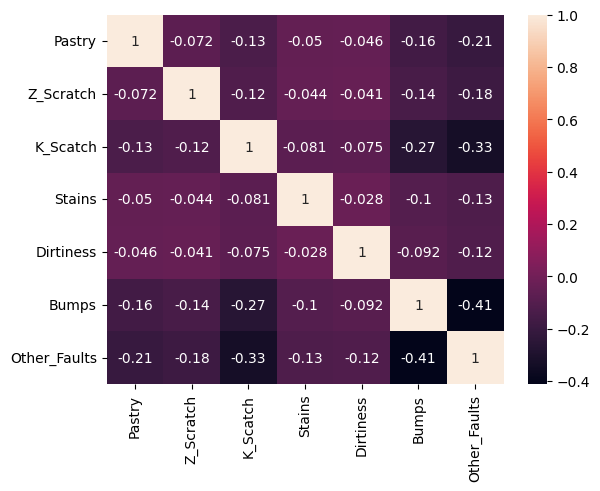

In [3]:
sns.heatmap(y.corr(), annot=True)

array([[<Axes: title={'center': 'Pastry'}>,
        <Axes: title={'center': 'Z_Scratch'}>,
        <Axes: title={'center': 'K_Scatch'}>],
       [<Axes: title={'center': 'Stains'}>,
        <Axes: title={'center': 'Dirtiness'}>,
        <Axes: title={'center': 'Bumps'}>],
       [<Axes: title={'center': 'Other_Faults'}>, <Axes: >, <Axes: >]],
      dtype=object)

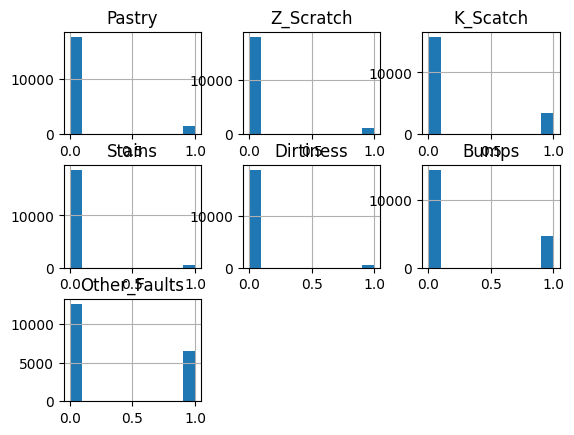

In [5]:
y.hist()

In [6]:
for col in y:
    print(f'Number of defects of type {col}',sum(y[col] == 1))

print('Number of no faults:',sum(np.sum(y, axis=1) == 0))
print('Number of one fault:',sum(np.sum(y, axis=1) == 1))
print('Number of two faults:',sum(np.sum(y, axis=1) == 2))

Number of defects of type Pastry 1466
Number of defects of type Z_Scratch 1150
Number of defects of type K_Scatch 3432
Number of defects of type Stains 568
Number of defects of type Dirtiness 485
Number of defects of type Bumps 4763
Number of defects of type Other_Faults 6558
Number of no faults: 818
Number of one fault: 18380
Number of two faults: 21


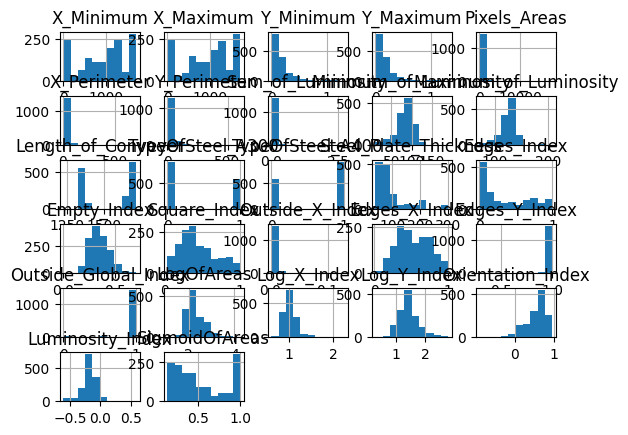

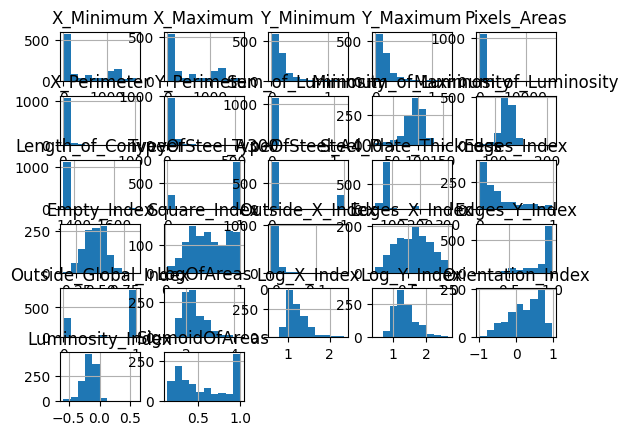

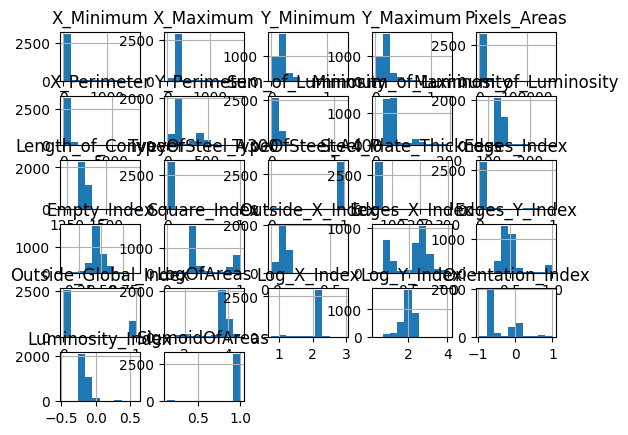

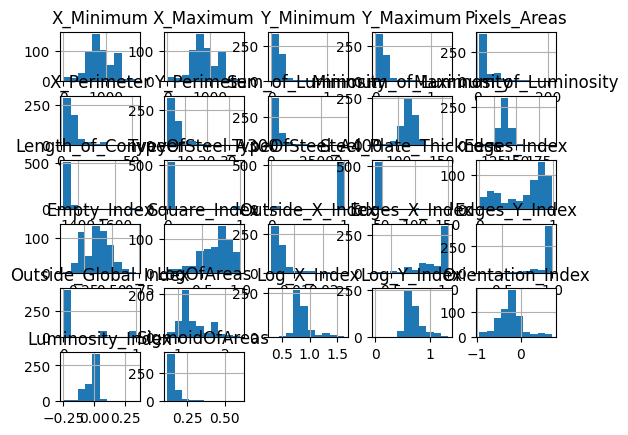

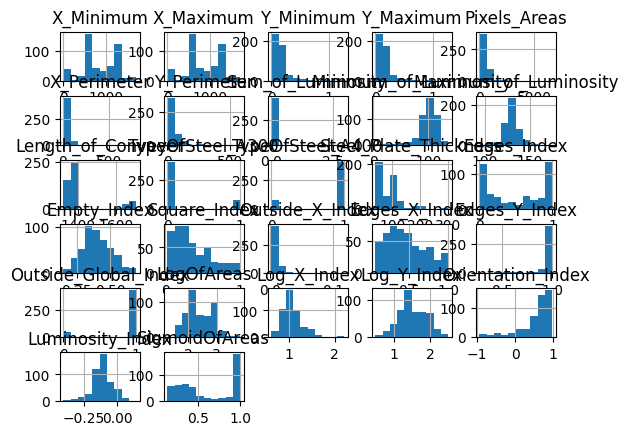

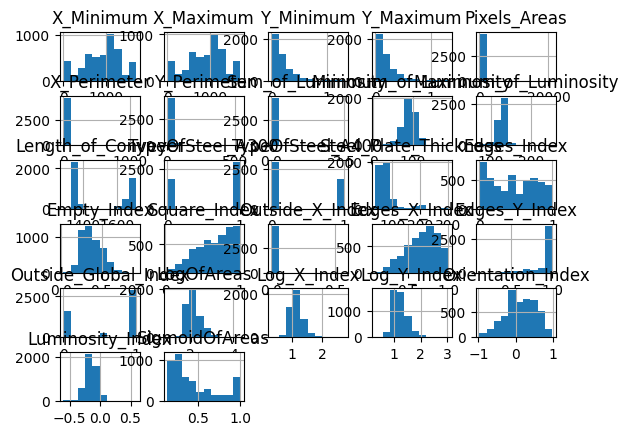

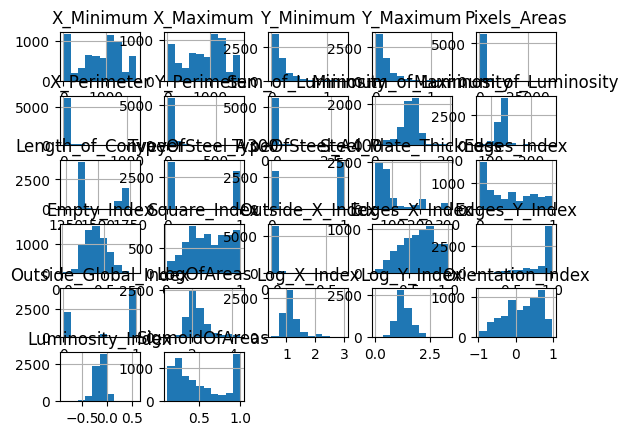

In [7]:
for col in y.columns:
    X[y[col]==1].hist()

In [8]:
def check_corr():
    col = 'Pastry'
    t = pd.concat((X_train,y_train[col]),axis=1).corr().iloc[:,-1]
    #print(t)
    for col in y_train.iloc[:,1:]:
        c = pd.concat((X_train,y_train[col]),axis=1).corr().iloc[:,-1]
        t = pd.concat((t,c),axis=1)

    sns.heatmap(t.iloc[:-7,:])

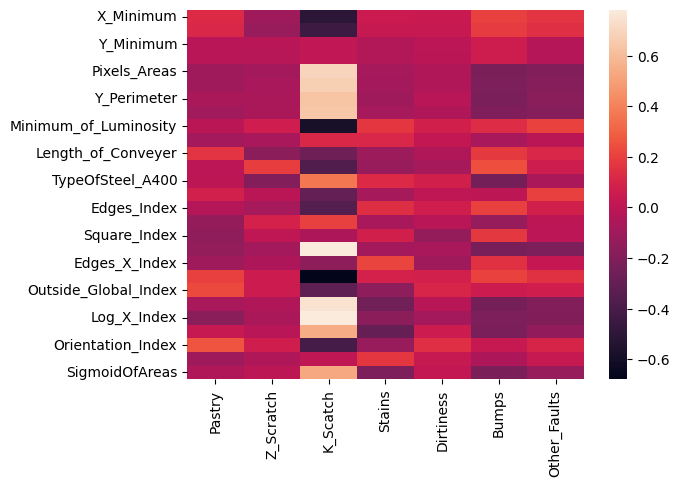

In [9]:
check_corr()

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
def check_number_of_PC():
    exp_var = []
    mms = MinMaxScaler()
    for i in range(X.shape[1]):
        
        pca = PCA(n_components = i)
        pca.fit(mms.fit_transform(X))
        exp_var.append(sum(pca.explained_variance_ratio_))
        
    sns.lineplot(x=range(0,X.shape[1]), y=exp_var)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


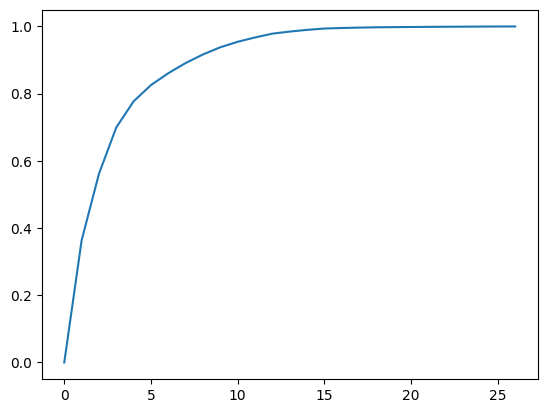

In [11]:
check_number_of_PC()

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [92]:
def sample_for_category(X_train,y_train,col, idxs_to_include_in_X ):
    X_train_copy = pd.concat((X_train,y_train.iloc[:,idxs]),axis=1).drop(col,axis=1,errors='ignore')
    #X_train_copy = X_train
    #print(X_train_copy.columns)
    #print(col)
    number_of_positive = sum(y_train[col] == 1)
    y_neg = y_train[y_train[col] == 0]
    X_neg = X_train_copy[y_train[col] == 0]
    y_pos = y_train[y_train[col] == 1]
    X_pos = X_train_copy[y_train[col] == 1]
    #idxs_for_neg = np.random.choice(range(y_neg.shape[0]), min(3*number_of_positive,y_neg.shape[0]),
    #                                replace= False)
    idxs_for_neg = range(X_neg.shape[0])
    X_neg = X_neg.iloc[idxs_for_neg]
    y_neg = y_neg.iloc[idxs_for_neg]
    pos = pd.concat((X_pos,y_pos[col]),axis=1)
    neg = pd.concat((X_neg,y_neg[col]),axis=1)
    df = pd.concat((neg,pos), axis=0)
    df = df.sample(frac = 1)
    return df.iloc[:,:-1], df.iloc[:,-1]

In [94]:
sum(y_TESTING_F==1)

477

In [109]:
def train_predict(estimator,X_train,y_train, X_val, y_val):
    res_preds = np.empty((y_val.shape[0],0))
    train_preds = np.empty((y_train.shape[0],0))
    train_roc = []
    idxs_to_include_in_X = []#EMPTY FOR COMMON PREDICTIONS. If not empty, predictions will be made on part of y_val
    for col in y:
        X_sampled,y_sampled = sample_for_category(X_train,y_train,col,idxs_to_include_in_X)
        
        estimator.fit(X_sampled,y_sampled)
        pr = estimator.predict_proba(X_sampled)[:,1]
        train_roc.append(roc_auc_score(y_sampled, pr))
        preds = estimator.predict_proba(pd.concat((X_val,y_val.iloc[:,idxs_to_include_in_X]),axis=1).drop(col,axis=1,errors='ignore'))[:,1]
        #estimator.fit(X_train,y_train[col])
        #pr = estimator.predict_proba(X_train)[:,1]
        #train_roc.append(roc_auc_score(y_train[col], pr))
        #preds = estimator.predict_proba(X_val))[:,1]
        
        preds = np.expand_dims(preds, axis=1 )
        pr = np.expand_dims( pr, axis=1 )
        res_preds = np.concatenate((res_preds,preds),axis=1)
        
        train_preds = np.concatenate((train_preds,pr),axis=1)
        print(f'{col} predicted')
        
    return res_preds, train_roc, train_preds

In [110]:
from sklearn.metrics import roc_auc_score
def get_avg_roc_auc(target, predicted):
    roc =  []
    for i in range(target.shape[1]):
        roc.append(roc_auc_score(target.iloc[:,i], predicted[:,i]))
    return roc

In [111]:
from sklearn.pipeline import Pipeline

In [112]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('LGBMClassifier', LGBMClassifier(max_depth=4,
                                                   learning_rate=0.01,
                                                   n_estimators=1500,
                                                   verbose = -1))])

res_preds,train_roc,train_preds = train_predict(pipe,X_train,y_train, X_val, y_val)
roc = get_avg_roc_auc(y_val, res_preds)

Pastry predicted
Z_Scratch predicted
K_Scatch predicted
Stains predicted
Dirtiness predicted
Bumps predicted
Other_Faults predicted


In [113]:
print('train',train_roc)
print('validation',roc)
print(np.mean(train_roc), np.mean(roc))

train [0.9427015830281592, 0.9882259207047025, 0.9953365449324031, 0.9995250704771127, 0.9881649055395454, 0.871656025444871, 0.8006609116421648]
validation [0.8831131508205999, 0.9539447441985677, 0.9865347666192225, 0.9933141063883112, 0.8878260377571996, 0.8087058694486928, 0.704559363059264]
0.9408958516812798 0.888285434041694


In [22]:
np.mean(roc[:-3])

0.9542266920066753

In [23]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('LGBMClassifier', LGBMClassifier(max_depth=4,
                                                   learning_rate=0.01,
                                                   n_estimators=1500,
                                                   verbose = -1))])

In [24]:
def train_custom_chain(pipe,X_train,y_train, X_val, y_val, X_idxs, y_idx):
    res_preds,train_roc,train_preds = train_predict(pipe,X_train,y_train, X_val, y_val)#GET ALL PREDICTIONS
    y_new = pd.DataFrame(train_preds, columns = y.columns)
    y_train = y_train.reset_index(drop=True)
    X_train = X_train.reset_index(drop=True)
    y_new = y_new.reset_index(drop=True)
    X_new = pd.concat((X_train,y_new.iloc[:,X_idxs]),axis=1)
    
    pipe.fit(X_new, y_train.iloc[:,y_idx])#FIT WITH SOME OF Y
    
    return res_preds, train_roc, train_preds

In [25]:
def validate_custom_chain(pipe, X_val, y_val,val_preds, X_idxs,y_idx ):
    y_idxs = list(set(range(y_val.shape[1])).difference(set(X_idxs)))
    
    y_new = pd.DataFrame(val_preds, columns = y.columns)
    X_val = X_val.reset_index(drop=True)
    y_new = y_new.reset_index(drop=True)
    probas = pipe.predict_proba(pd.concat((X_val,y_new.iloc[:,X_idxs]),axis=1))#PREDICT PROBABILITY FOR JOINT X_val AND SOME OF Y for columns y_idxs
    
    
    roc = get_avg_roc_auc(y_val.iloc[:,y_idx],np.expand_dims(probas[:,1], axis=1))
    return roc

In [26]:
val_preds, train_roc, train_preds = train_custom_chain(pipe,X_train,y_train, X_val, y_val,X_idxs = [0,1,2,3], y_idx=6)

Pastry predicted
Z_Scratch predicted
K_Scatch predicted
Stains predicted
Dirtiness predicted
Bumps predicted
Other_Faults predicted


In [27]:
predictions = validate_custom_chain(pipe, X_val, y_val,val_preds,X_idxs = [0,1,2,3], y_idx=[6] )

In [28]:
predictions

[0.6859130578505208]

In [ ]:
print('train',train_roc)
print('validation',roc)
print(np.mean(train_roc), np.mean(roc))

In [ ]:
print(np.mean(roc[:-2]))

In [29]:
def cross_validate(est, X_train,y_train,cv):
    score = []
    for col in y.columns:
        X_sampled,y_sampled = sample_for_category(X_train,y_train,col)
        s = cross_val_score(est,X_sampled,y_sampled,scoring='roc_auc', cv=cv)
        
        #s = cross_val_score(est,X_train,y_train[col],scoring='roc_auc', cv=cv)
        
        print(col,'predicted')
        score.append(s)
    return score



In [30]:
cv_score = cross_validate(pipe, X_train,y_train,5)
print(cv_score)

Pastry predicted
Z_Scratch predicted
K_Scatch predicted
Stains predicted
Dirtiness predicted
Bumps predicted
Other_Faults predicted
[array([0.89120501, 0.8563854 , 0.85739827, 0.83748454, 0.87853161]), array([0.95748598, 0.95286323, 0.9625    , 0.94170579, 0.96075527]), array([0.98515133, 0.98570022, 0.98615779, 0.9849092 , 0.98142198]), array([0.98532918, 0.98812646, 0.99322552, 0.98991535, 0.98995215]), array([0.86401042, 0.87088542, 0.85994792, 0.87463542, 0.87427083]), array([0.79797139, 0.80053324, 0.81234257, 0.81075697, 0.80481235]), array([0.69341062, 0.69951998, 0.71163257, 0.69146506, 0.69516905])]


In [25]:
from sklearn.multioutput import ClassifierChain

In [26]:
base_classifier = LGBMClassifier(max_depth=4,
                                 learning_rate=0.01,
                                 n_estimators=1500,
                                 verbose = -1)
chain = ClassifierChain(base_classifier, order=[3,2,1,4,0,5,6]) #,0,4,5,6
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('chain_classifier',chain)])

In [27]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('chain_classifier',
                 ClassifierChain(base_estimator=LGBMClassifier(learning_rate=0.01,
                                                               max_depth=4,
                                                               n_estimators=1500,
                                                               verbose=-1),
                                 order=[3, 2, 1, 4, 0, 5, 6]))])

In [28]:
preds = pipe.predict_proba(X_val)

In [29]:
#preds
#[0.861739144774815, 0.9544909419267452, 0.9822636620765808, 0.9892860748418361, 0.8527286072014506, 0.8043661259299397, 0.6994159913382985]
avg_roc= get_avg_roc_auc(y_val, preds)

In [30]:
avg_roc

[0.8653494683207799,
 0.9581431125596475,
 0.9827954559868087,
 0.9959745342399048,
 0.8488119249397321,
 0.8033996683250415,
 0.6043242781524032]

In [37]:
np.mean(avg_roc[:-3])

0.9505656427767851

In [ ]:
cross_val_score(pipe,X,y,scoring='roc_auc', cv=5)

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('LGBMClassifier', LGBMClassifier(max_depth=4,
                                                   learning_rate=0.01,
                                                   n_estimators=1500,
                                                   verbose = -1))])
#pipe = Pipeline([('scaler', MinMaxScaler()), ('SVM', SVC(probability=True,kernel='poly'))])

In [ ]:
scores = cross_validate(pipe,X,y,cv=5)
print(scores)
print(np.mean(scores))


In [ ]:
SAVED_custom_sample_false_and_negative = {'SVM linear':0.8585,
        'SVM poly' :0.8646,
        'SVM rbf':,
        'lightGBM_default':0.8734,
        'lightGBM:md=4,lr=0.01, n_estimators=1500':0.8826,           
        }

SAVED_default = {
        'lightGBM_default':0.882,
        'lightGBM:md=4,lr=0.01, n_estimators=1500':0.8855,                                 
        }

In [ ]:
def write_results(estimator):
    df = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
    ids = df['id']
    X = df.drop('id',axis=1)
    
    res_preds = np.empty((X.shape[0],0))
    res_df = pd.DataFrame()
    for col in y:
    
        preds = np.expand_dims( estimator.predict_proba(X)[:,1], axis=1 )
        #res_preds = np.concatenate((res_preds,preds),axis=1)
        #print(preds[:,0])
        res_df[col] = preds[:,0]
    res_df['id'] = ids
    
    res_df.to_csv('submission.csv')
    return res_df

In [ ]:
reses = write_results(pipe)

In [ ]:
reses

In [39]:
 from sklearn.multioutput import MultiOutputClassifier

In [43]:
X_train

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
8989,953,962,4443762,4443777,103,14,15,10284,78,125,...,0.0060,0.7143,1.0000,1.0,2.0128,1.0000,1.1761,0.4000,-0.2298,0.2469
16289,845,856,3160372,3160387,67,13,11,6342,93,119,...,0.0066,0.6923,1.0000,1.0,1.8261,0.9542,1.0414,0.1818,-0.1681,0.2051
16257,729,742,1301932,1301945,227,22,28,32920,88,135,...,0.0053,0.4091,1.0000,1.0,2.3560,0.9542,1.4150,0.6923,-0.1215,0.7512
802,1223,1237,1709640,1709661,138,25,23,15501,90,125,...,0.0096,0.5200,1.0000,1.0,2.1399,1.1139,1.3617,0.6071,-0.1926,0.3285
9866,7,19,1638648,1638668,217,38,30,24102,99,127,...,0.0071,0.4211,1.0000,1.0,2.3365,1.0792,1.4771,0.8000,-0.1268,0.5296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,576,578,3020344,3020360,71,9,20,7842,92,130,...,0.0052,0.7778,1.0000,1.0,1.8513,0.8451,1.3010,0.6500,-0.1499,0.2532
4706,1219,1238,2528213,2528283,145,30,18,14538,87,119,...,0.0176,0.8000,0.6667,0.0,2.1644,1.3802,1.2553,-0.3333,-0.2130,0.6330
18620,6,15,2887095,2887114,138,17,11,12465,77,108,...,0.0053,0.5294,1.0000,1.0,2.1335,0.9542,1.0414,0.3889,-0.2611,0.3419
10731,39,214,1422717,142260,6234,247,133,686356,41,127,...,0.1291,0.7172,0.5000,0.0,3.8450,2.2430,1.8325,-0.6242,-0.1854,1.0000


In [45]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('LGBMClassifier', LGBMClassifier(max_depth=4,
                                                   learning_rate=0.01,
                                                   n_estimators=1500,
                                                   verbose = -1))])

In [79]:
base_classifier = LGBMClassifier(max_depth=4,
                                 learning_rate=0.01,
                                 n_estimators=1500,
                                 verbose = -1)
chain = ClassifierChain(base_classifier, order=[3,2,1,4,0,5,6]) #,0,4,5,6
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('chain_classifier',chain)])

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('LGBMClassifier', LGBMClassifier(max_depth=4,
                                                   learning_rate=0.01,
                                                   n_estimators=1500,
                                                   verbose = -1))])

In [80]:
def fit_predict_calculate_auc(pipe):
    moc = MultiOutputClassifier(pipe)
    moc.fit(X_train,y_train)
    preds = moc.predict_proba(X_val)
    new_preds = []
    for pred in preds:
        new_preds.append(pred[:,1])
        
    score = roc_auc_score(y_val, np.array(new_preds).T)
    return score

In [ ]:
score = fit_predict_calculate_auc(pipe)

In [ ]:
cross_val_score(pipe,X,y)